# Goal
1. Achieving accuracy above ninety percent for data

2. Acceptable results for real images

3. Use model in mobile devices

# Basic Imports

In [1]:
import torch
from torch import nn 
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torchinfo
from torchinfo import summary
from tqdm.auto import tqdm
import time
import random
import os
from sklearn.metrics import accuracy_score

import os
import random 

/home/alireza/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(f"torch version : {torch.__version__} | torchvision version : {torchvision.__version__}")

torch version : 2.0.1+cu117 | torchvision version : 0.15.2+cu117


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Prepare Data / clothing-dataset-small

In [6]:
from pathlib import Path
data_path = Path("/media/alireza/SSD/Vision_Project/clothing-dataset-small")

train_path = data_path / "train"

test_path = data_path / "test"

val_path = data_path / "validation"

In [7]:
from pathlib import Path

def data_path(path:str):
    """
    This function get path of data-set folder and return train_path , test_path , val_path with
    \n pathlib.PosixPath type

    Example:
    train_path , test_path , val_path =  data_path("data_set dir with str type")
    """
    data_path = Path(path)

    train_path = data_path / "train"

    test_path = data_path / "test"

    val_path = data_path / "validation"

    return train_path , test_path , val_path

In [8]:
train_path , test_path , val_path =  data_path("/media/alireza/SSD/Vision_Project/clothing-dataset-small")

### visualization images

Random image paths

In [10]:
next(iter(os.walk(train_path)))

('/media/alireza/SSD/Vision_Project/clothing-dataset-small/train',
 ['dress',
  'hat',
  'longsleeve',
  'outwear',
  'pants',
  'shirt',
  'shoes',
  'shorts',
  'skirt',
  't-shirt'],
 [])

In [11]:
import os
import random 

def walk_dirs(directory):
    """Directory tree generator for a dataset path like train_path dir
    """
    
    for root , dirs , files in os.walk(directory):
        print(f"Root : {Path(root).stem} | Dirs : {len(dirs)} | files : {len(files)}")

walk_dirs(train_path)

Root : train | Dirs : 10 | files : 0
Root : dress | Dirs : 0 | files : 241
Root : hat | Dirs : 0 | files : 123
Root : longsleeve | Dirs : 0 | files : 455
Root : outwear | Dirs : 0 | files : 184
Root : pants | Dirs : 0 | files : 468
Root : shirt | Dirs : 0 | files : 290
Root : shoes | Dirs : 0 | files : 198
Root : shorts | Dirs : 0 | files : 202
Root : skirt | Dirs : 0 | files : 112
Root : t-shirt | Dirs : 0 | files : 795


In [12]:
walk_dirs(test_path)

Root : test | Dirs : 10 | files : 0
Root : dress | Dirs : 0 | files : 15
Root : hat | Dirs : 0 | files : 12
Root : longsleeve | Dirs : 0 | files : 72
Root : outwear | Dirs : 0 | files : 38
Root : pants | Dirs : 0 | files : 42
Root : shirt | Dirs : 0 | files : 26
Root : shoes | Dirs : 0 | files : 73
Root : shorts | Dirs : 0 | files : 30
Root : skirt | Dirs : 0 | files : 12
Root : t-shirt | Dirs : 0 | files : 52


In [13]:
walk_dirs(val_path)

Root : validation | Dirs : 10 | files : 0
Root : dress | Dirs : 0 | files : 32
Root : hat | Dirs : 0 | files : 14
Root : longsleeve | Dirs : 0 | files : 49
Root : outwear | Dirs : 0 | files : 24
Root : pants | Dirs : 0 | files : 49
Root : shirt | Dirs : 0 | files : 29
Root : shoes | Dirs : 0 | files : 26
Root : shorts | Dirs : 0 | files : 25
Root : skirt | Dirs : 0 | files : 12
Root : t-shirt | Dirs : 0 | files : 81


In [14]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt

from pathlib import Path

def original_random_image_show(data_path,
                             seed:int = 42,
                             rows:int=3,
                             cols:int=3):
    """This function show nrows*ncols image from original dataset with their shapes
    """
    random.seed(seed)

    data_path = Path(data_path)

    image_path_list = list(data_path.glob("*/*/*.jpg"))


    rows = rows
    cols = cols
    fig  = plt.figure(figsize=(16,14))

    for i in range(1 , rows * cols +1):
        fig.add_subplot(rows,cols,i)
        image_random_path = random.choice(image_path_list)
    
        im_read = plt.imread(image_random_path)

        title = f" {image_random_path.parent.stem} | {im_read.shape} " 
        plt.imshow(im_read)
        plt.axis(False)
        plt.title(title)
    

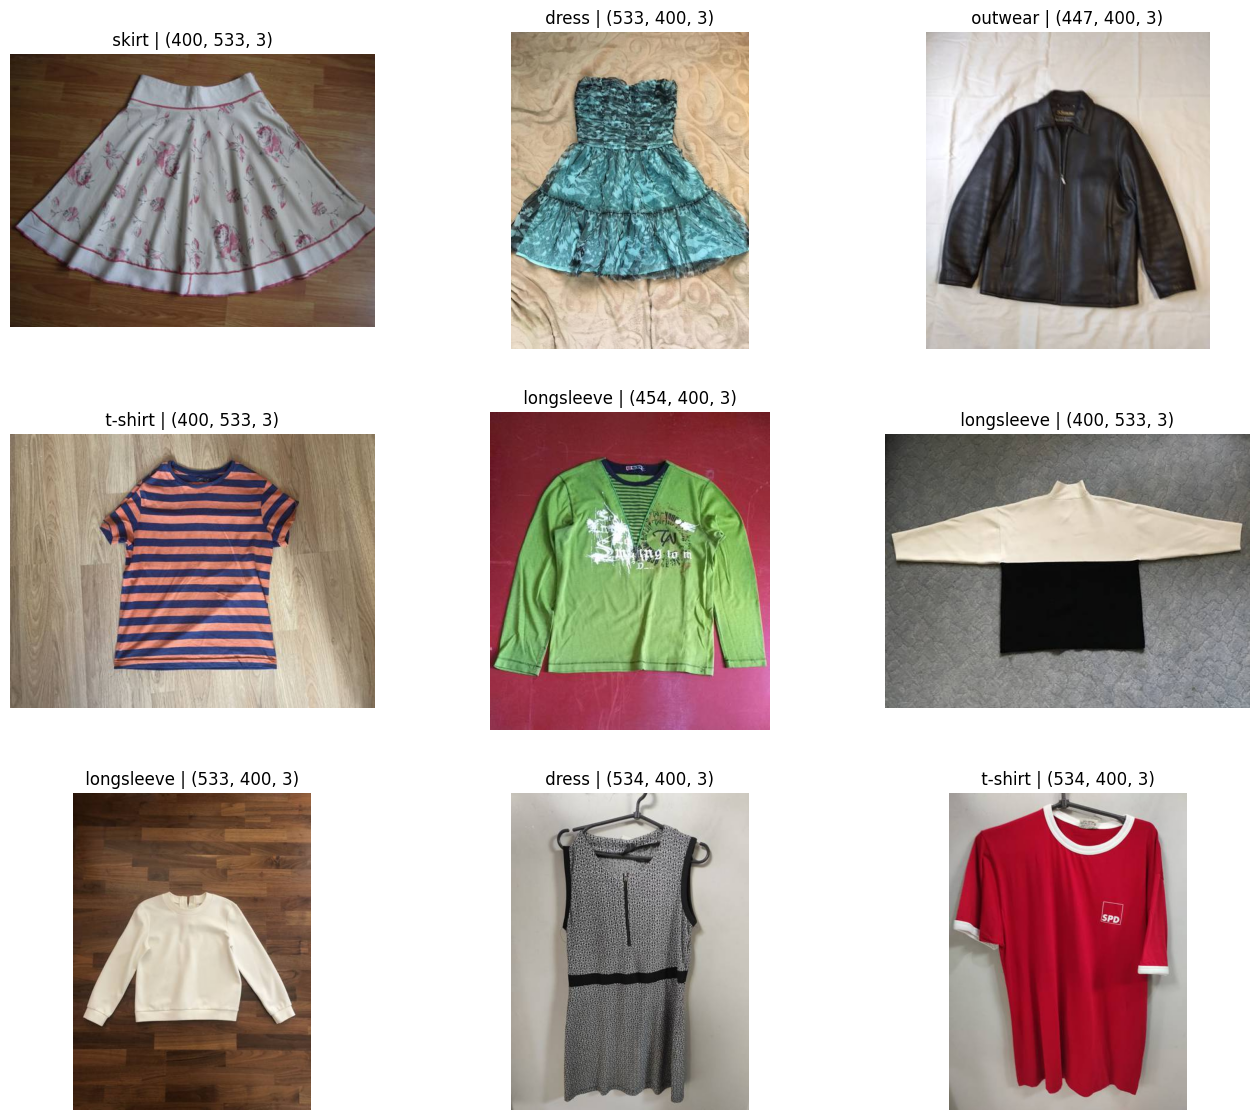

In [15]:
original_random_image_show("/media/alireza/SSD/Vision_Project/clothing-dataset-small")

## Create Dataset

In [16]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224,224),antialias=True),
    transforms.RandomCrop(size=(224,224)),
    transforms.RandomRotation(degrees=(0,10))
]
)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224,224),antialias=True)])

In [9]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from pathlib import Path

def creat_dataloaders(train_path : None,
                      test_path : None,
                      val_path : None,
                      batch_size : int,
                      train_transform : transforms,
                      test_transform  : transforms,
                      seed : int):
    """This function build dataloaders


    Args:
    train_path : path of train data
    test_path : path of test data
    val_path : path of val data
    batch_size : number of data samples in each batch
    train_transform : data transform for train data
    test_transform : data transform for test data
    seed : for reproducibility of results

    Return:
    \ntrain_dataloader , test_dataloader , val_dataloader , class_names , class_idx
    """
    torch.manual_seed(seed = seed)
    torch.cuda.manual_seed(seed=seed)
    
    train_data = datasets.ImageFolder(root=train_path,
                                    transform=train_transform)

    test_data = datasets.ImageFolder(root=test_path,
                                        transform=test_transform)
    if val_path  is not None :
        val_data = datasets.ImageFolder(root=val_path,
                                        transform=test_transform)
        val_dataloader = DataLoader(val_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=os.cpu_count(),
                                pin_memory=True,
                                drop_last=True)
        

    train_dataloader = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=os.cpu_count(),
                                pin_memory=True,
                                drop_last=True)

    test_dataloader = DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=os.cpu_count(),
                                pin_memory=True,
                                drop_last=True)
    
    class_names = train_data.classes
    class_idx = train_data.class_to_idx

    if val_dataloader :
        return train_dataloader , test_dataloader , val_dataloader , class_names , class_idx
    else:
        return train_dataloader , test_dataloader , class_names , class_idx



In [18]:
train_dataloader , test_dataloader , val_dataloader , class_names , class_idx =  creat_dataloaders(train_path=train_path,
                                                                                                   test_path=test_path,
                                                                                                   val_path=val_path,
                                                                                                   batch_size=32,
                                                                                                   train_transform=train_transform,
                                                                                                   test_transform=test_transform,
                                                                                                   seed=42)

In [19]:
len(train_dataloader) , len(test_dataloader) , len(val_dataloader)

(95, 11, 10)

Chek shapes


def visulize_transfomed_images(dataset : torchvision.datasets , rows:int , cols:int):
    """This function show nrows*ncols image from transformed datasets with their labels
    """

    fig = plt.figure(figsize=(10,6))
    rows =rows
    cols = cols
    for i in range(1 ,rows*cols +1):
        random_image_idx = random.choice(list(range(len(dataset))))
        
        fig.add_subplot(rows,cols,i)

        plt.imshow(dataset[random_image_idx][0].permute(1,2,0));
        plt.axis(False)
        plt.title(class_names[dataset[random_image_idx][1]])


need to change in fucntion for transformed image

Visulize transformed images

To DtatLpaders

In [20]:
train_dataloader , test_dataloader , val_dataloader , class_names , class_idx

(<torch.utils.data.dataloader.DataLoader at 0x7f8b36ddf490>,
 ['dress',
  'hat',
  'longsleeve',
  'outwear',
  'pants',
  'shirt',
  'shoes',
  'shorts',
  'skirt',
  't-shirt'],
 {'dress': 0,
  'hat': 1,
  'longsleeve': 2,
  'outwear': 3,
  'pants': 4,
  'shirt': 5,
  'shoes': 6,
  'shorts': 7,
  'skirt': 8,
  't-shirt': 9})

# Create a Base model

The Architecture of Alex_net 

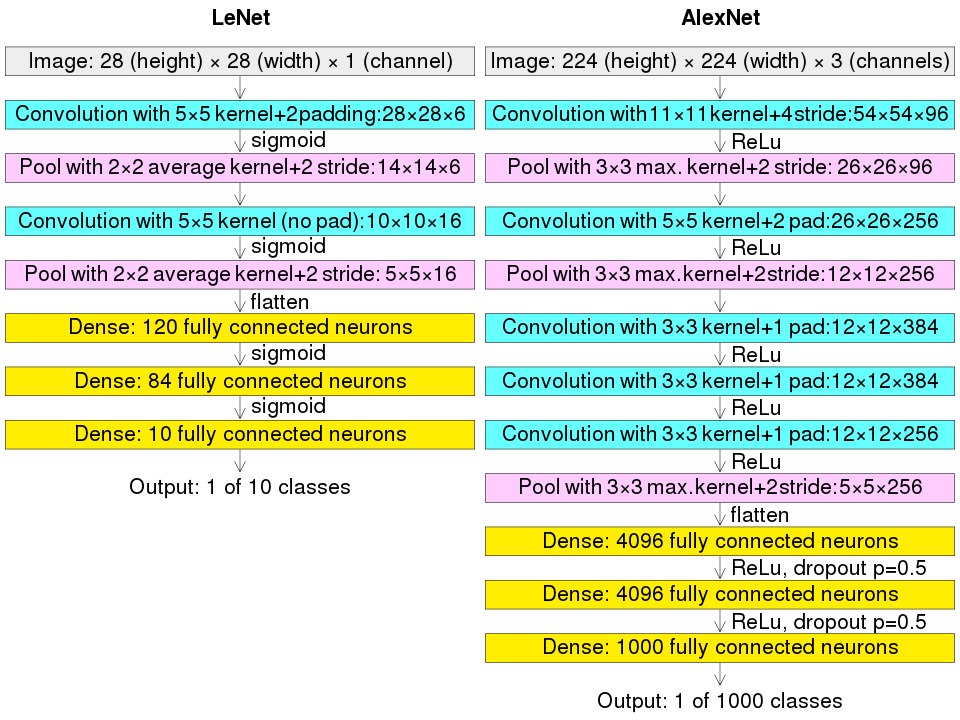

In [21]:
HIDDEN_UNITS = 96

In [22]:
class Alex_net(nn.Module):
    def __init__(self,input_shape , hidden_units , output_shape):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size= 11,
                      stride=4),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3,
                         stride=2),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=256,
                      kernel_size=5,
                      padding=2),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=3,
                         stride=2),
            
            nn.Conv2d(in_channels=256,
                      out_channels=384,
                      kernel_size=3,
                      padding=1),
            
            nn.ReLU(),

            nn.Conv2d(in_channels=384,
                      out_channels=384,
                      kernel_size=3,
                      padding=1),
            
            nn.ReLU(),

            
            nn.Conv2d(in_channels=384,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=3,
                         stride=2)
        )
        self.classification = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(in_features=6400,
                     out_features=4096),

            nn.ReLU(),

            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096,
                      out_features=4096),
            
            nn.ReLU(),

            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096,
                      out_features=output_shape)
        )
    def forward(self , x):
        return self.classification(self.conv_block(x))

        

#### Check the model 

In [23]:
Alex_net_v1 = Alex_net(input_shape=3,output_shape=len(class_names),hidden_units=HIDDEN_UNITS).to(device)

In [24]:
image_batch, image_label = next(iter(train_dataloader))
image_single = image_batch[0].unsqueeze(dim=0)
image_single_label = image_label[0]

image_single.shape , image_single_label

(torch.Size([1, 3, 224, 224]), tensor(9))

In [25]:
Alex_net_v1.eval()
with torch.inference_mode():
    single_pred = Alex_net_v1(image_single.to(device))

single_pred.shape , torch.argmax(torch.softmax(single_pred , dim=1)) 

(torch.Size([1, 10]), tensor(5, device='cuda:0'))

In [26]:
summary(model=Alex_net_v1,
        input_size=[1,3,224,224])

Layer (type:depth-idx)                   Output Shape              Param #
Alex_net                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 5, 5]            --
│    └─Conv2d: 2-1                       [1, 96, 54, 54]           34,944
│    └─ReLU: 2-2                         [1, 96, 54, 54]           --
│    └─MaxPool2d: 2-3                    [1, 96, 26, 26]           --
│    └─Conv2d: 2-4                       [1, 256, 26, 26]          614,656
│    └─ReLU: 2-5                         [1, 256, 26, 26]          --
│    └─MaxPool2d: 2-6                    [1, 256, 12, 12]          --
│    └─Conv2d: 2-7                       [1, 384, 12, 12]          885,120
│    └─ReLU: 2-8                         [1, 384, 12, 12]          --
│    └─Conv2d: 2-9                       [1, 384, 12, 12]          1,327,488
│    └─ReLU: 2-10                        [1, 384, 12, 12]          --
│    └─Conv2d: 2-11                      [1, 256, 12, 12]       

## Train of Model

In [10]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings

def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [11]:
from torch.utils.tensorboard import SummaryWriter
import torch
def train_model(
        model : torch.nn.Module ,
        train_dataloader : DataLoader,
        test_dataloader : DataLoader,
        loss_function : torch.nn,
        optimizer : torch.optim,
        epoch_number : int ,
        metric_function : None,
        device : None,
        writer : SummaryWriter):
    

    ### save the loss and accuracy per epoch
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []
    test_loss_list = []


    for epochs in tqdm(range(epoch_number)):

        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0

        print(f"Number of Epoch : {epochs + 1}")

        ### train step of train model
        for batch , (X ,y) in enumerate(train_dataloader):

            X , y = X.to(device) , y.to(device)

            model.train()

            y_preds = model(X)

            loss = loss_function(y_preds , y)
            
            ### for syncing the devices
            loss_ = loss.cpu().detach().numpy()

            train_loss += loss_

            y_preds_label = torch.argmax(torch.softmax(y_preds,dim=1),dim=1)

            acc = metric_function(y.cpu(),y_preds_label.cpu())

            train_acc += acc

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        ### Avarege loss and acc of train
        train_loss = train_loss / len(train_dataloader)
        train_acc = train_acc / len(train_dataloader)
        ### save data in list
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)


        ### test step of train model
        model.eval()
        with torch.inference_mode():
            for batch , (X , y) in enumerate(test_dataloader):
                X , y = X.to(device) , y.to(device)

                y_preds_test = model(X)

                loss_test = loss_function(y_preds_test , y)
                
                ### for syncing the devices
                loss_test_ = loss_test.cpu().detach().numpy()
                test_loss += loss_test_

                ### calculate accuracy
                y_preds_label_test = torch.argmax(torch.softmax(y_preds_test,dim=1),dim=1)

                acc = metric_function(y.cpu(),y_preds_label_test.cpu())

                test_acc += acc
        ### avarage of loss an acc in test step
        test_acc = test_acc / len(test_dataloader)
        test_loss = test_loss / len(test_dataloader)
        
        ### save data in test step
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        print(f"train loss : {train_loss} | train acc : {train_acc} | test loss : {test_loss} | test acc : {test_acc}")
        
        writer.add_scalars(main_tag = "Loss",
                      tag_scalar_dict ={
                          "train_loss" : train_loss,
                          "test_loss" :test_loss
                      },global_step=epochs)
    
        writer.add_scalars(main_tag = "Accuracy",
                    tag_scalar_dict ={
                        "train_acc" : train_acc,
                        "test_acc" :test_acc
                    },global_step=epochs)
        
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32,3,224,224).to(device))
        
    writer.close()
    model_results = {
        "train_loss" : train_loss_list,
        "train_accuracy" : train_acc_list,
        "test_loss" : test_loss_list,
        "test_accuracy" : test_acc_list
    }

    return model_results


In [29]:
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=Alex_net_v1.parameters(),
                             lr=0.01)

In [37]:
writer = create_writer(experiment_name="Base_model",
                                         model_name="Alex_net")

[INFO] Created SummaryWriter, saving to: runs/2023-11-04/Base_model/Alex_net...


In [38]:
base_alex_net_result = train_model(model=Alex_net_v1,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_function=loss_function,
                                   optimizer=optimizer,
                                   epoch_number=10,
                                   metric_function=accuracy_score,
                                   device=device,
                                   writer=writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Number of Epoch : 1
train loss : 2.12979247068104 | train acc : 0.25953947368421054 | test loss : 2.3344169096513228 | test acc : 0.13920454545454544


 10%|█         | 1/10 [00:31<04:45, 31.72s/it]

Number of Epoch : 2
train loss : 2.12597622620432 | train acc : 0.2598684210526316 | test loss : 2.2692322731018066 | test acc : 0.14204545454545456


 20%|██        | 2/10 [01:03<04:13, 31.69s/it]

Number of Epoch : 3
train loss : 2.1269791791313573 | train acc : 0.2588815789473684 | test loss : 2.329541336406361 | test acc : 0.13636363636363635


 30%|███       | 3/10 [01:34<03:39, 31.33s/it]

Number of Epoch : 4
train loss : 2.1241711641612806 | train acc : 0.25953947368421054 | test loss : 2.3011968569322065 | test acc : 0.14204545454545456


 40%|████      | 4/10 [02:04<03:05, 30.85s/it]

Number of Epoch : 5
train loss : 2.1280283036984895 | train acc : 0.25953947368421054 | test loss : 2.2889881784265693 | test acc : 0.13352272727272727


 50%|█████     | 5/10 [02:35<02:35, 31.05s/it]

Number of Epoch : 6
train loss : 2.1201171887548345 | train acc : 0.25953947368421054 | test loss : 2.291649514978582 | test acc : 0.14204545454545456


 60%|██████    | 6/10 [03:06<02:03, 30.95s/it]

Number of Epoch : 7
train loss : 2.1268344929343774 | train acc : 0.2578947368421053 | test loss : 2.299961740320379 | test acc : 0.13636363636363635


 70%|███████   | 7/10 [03:36<01:32, 30.68s/it]

Number of Epoch : 8
train loss : 2.1235403964394015 | train acc : 0.2588815789473684 | test loss : 2.2770156643607398 | test acc : 0.14772727272727273


 80%|████████  | 8/10 [04:06<01:00, 30.50s/it]

Number of Epoch : 9
train loss : 2.1237401761506733 | train acc : 0.2565789473684211 | test loss : 2.2872006459669634 | test acc : 0.14204545454545456


 90%|█████████ | 9/10 [04:37<00:30, 30.66s/it]

Number of Epoch : 10
train loss : 2.121416601381804 | train acc : 0.2598684210526316 | test loss : 2.263523968783292 | test acc : 0.14488636363636365


100%|██████████| 10/10 [05:08<00:00, 30.85s/it]


# Use Original AlexNet Model

In [12]:
BATCH_SIZE = 32

In [32]:
weights = torchvision.models.AlexNet_Weights.DEFAULT

In [33]:
weights_transform = weights.transforms()

In [34]:
weights_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [35]:
train_dataloader_ori_Alex , test_dataloader_ori_Alex , val_dataloader_ori_Alex , class_names_ori_Alex , class_id_ori_Alex = creat_dataloaders(train_path=train_path,
                                                                                                 test_path=test_path,
                                                                                                 val_path=val_path,
                                                                                                 batch_size=BATCH_SIZE,
                                                                                                 train_transform=weights_transform,
                                                                                                 test_transform=weights_transform,
                                                                                                 seed=42)

In [36]:
Alex_net_original = torchvision.models.alexnet(weights=weights,progress=True).to(device)

In [37]:
loss_function_ori_Alex = nn.CrossEntropyLoss()

optimizer_ori_Alex = torch.optim.Adam(params=Alex_net_original.parameters(),
                             lr=0.01)

In [38]:
for param in Alex_net_original.parameters():
    param.requires_grad = False

In [39]:
Alex_net_original

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [40]:
Alex_net_original.classifier = nn.Sequential(
    nn.Dropout(p=0.5,inplace=True),
    nn.Linear(in_features=9216 , out_features=4096,bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=len(class_names), bias=True)

).to(device)

In [41]:
Alex_net_original

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
  

In [44]:
writer_ori_Alex = create_writer(experiment_name="Original_Alex_net",
                                         model_name="Alex_net")

[INFO] Created SummaryWriter, saving to: runs/2023-11-11/Original_Alex_net/Alex_net...


In [45]:
Alex_net_original_result = train_model(model=Alex_net_original,
                                       train_dataloader=train_dataloader_ori_Alex,
                                       test_dataloader=test_dataloader_ori_Alex,
                                       loss_function=loss_function_ori_Alex,
                                       optimizer=optimizer_ori_Alex,
                                       epoch_number=10,
                                       metric_function=accuracy_score,
                                       device=device,
                                       writer=writer_ori_Alex)

  0%|          | 0/10 [00:00<?, ?it/s]

Number of Epoch : 1
train loss : 2.323876385939749 | train acc : 0.10953947368421052 | test loss : 2.319869648326527 | test acc : 0.07102272727272728


 10%|█         | 1/10 [00:13<02:04, 13.88s/it]

Number of Epoch : 2
train loss : 2.331825522372597 | train acc : 0.0993421052631579 | test loss : 2.324208151210438 | test acc : 0.0625


 20%|██        | 2/10 [00:27<01:49, 13.73s/it]

Number of Epoch : 3
train loss : 2.3284658181039912 | train acc : 0.09572368421052632 | test loss : 2.3204797181216152 | test acc : 0.07386363636363637


 30%|███       | 3/10 [00:40<01:34, 13.56s/it]

Number of Epoch : 4
train loss : 2.323866307108026 | train acc : 0.10657894736842105 | test loss : 2.319504130970348 | test acc : 0.07102272727272728


 40%|████      | 4/10 [00:54<01:20, 13.42s/it]

Number of Epoch : 5
train loss : 2.3244708111411647 | train acc : 0.10559210526315789 | test loss : 2.320964813232422 | test acc : 0.06818181818181818


 50%|█████     | 5/10 [01:07<01:07, 13.50s/it]

Number of Epoch : 6
train loss : 2.322912376805356 | train acc : 0.10921052631578948 | test loss : 2.3212933106855913 | test acc : 0.06818181818181818


 60%|██████    | 6/10 [01:21<00:54, 13.54s/it]

Number of Epoch : 7
train loss : 2.322286093862433 | train acc : 0.10855263157894737 | test loss : 2.3209723342548716 | test acc : 0.07102272727272728


 70%|███████   | 7/10 [01:35<00:40, 13.65s/it]

Number of Epoch : 8
train loss : 2.3245807522221615 | train acc : 0.1006578947368421 | test loss : 2.3230456655675713 | test acc : 0.06818181818181818


 80%|████████  | 8/10 [01:48<00:26, 13.50s/it]

Number of Epoch : 9
train loss : 2.329252767562866 | train acc : 0.1006578947368421 | test loss : 2.320924693887884 | test acc : 0.06818181818181818


 90%|█████████ | 9/10 [02:01<00:13, 13.50s/it]

Number of Epoch : 10
train loss : 2.323370391444156 | train acc : 0.1 | test loss : 2.324360565705733 | test acc : 0.06534090909090909


100%|██████████| 10/10 [02:15<00:00, 13.56s/it]


* Why test loss and acc dosnt change?

* Your dataset is highly imbalanced. Your optimization process is just minimizing the loss function, and cannot do better than a model that predicts uninteresting regardless of the input, due to the fact that your training set is very imbalanced. Moreover, you are not overfitting, since your training accuracy is lower than your validation accuracy.

* In order to have a model that learns something less dummy than your model (and you might have to pay the price of having a lower accuracy), I would do the following: when providing a mini-batch to your optimizer, generate a mini-batch that is more balanced, that is, bias the elements you select towards the interesting articles. For instance, if your batch size is 64, ensure that it has 32 interesting elements and 32 uninteresting elements. Using this your network might start learning some features regarding the words in it, and in principle it should help you achieve a not so dummy predictor.

* change `shuffle` parameter to : `True` for `train,test,val` Dataloader 

## Use Powerfull Models (efficientnet_b2)

In [46]:
efficientnet_b2_weight = torchvision.models.EfficientNet_B2_Weights.DEFAULT

efficientnet_b2 = torchvision.models.efficientnet_b2(weights=efficientnet_b2_weight,progress=True).to(device)

eff_transform = efficientnet_b2_weight.transforms()

In [47]:
eff_transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [48]:
train_dataloader_eff_b2 , test_dataloader_eff_b2, val_dataloader_eff_b2 , class_names_eff_b2, class_id_eff_b2 = creat_dataloaders(train_path=train_path,
                                                                                                 test_path=test_path,
                                                                                                 val_path=val_path,
                                                                                                 batch_size=BATCH_SIZE,
                                                                                                 train_transform=eff_transform,
                                                                                                 test_transform=eff_transform,
                                                                                                 seed=42)

In [49]:
for param in efficientnet_b2.parameters():
    param.requires_grad = False

In [50]:
efficientnet_b2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [51]:
efficientnet_b2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)).to(device)

In [53]:
loss_function_eff_b2 = nn.CrossEntropyLoss()
optimizer_eff_b2 = torch.optim.Adam(params=efficientnet_b2.parameters(),
                                    lr = 0.01)

In [52]:
writer_eff_b2 = create_writer(experiment_name="Efficientnet_b2",
                                         model_name="efficientnet_b2")

[INFO] Created SummaryWriter, saving to: runs/2023-11-11/Efficientnet_b2/efficientnet_b2...


In [54]:
model_results_eff2 = train_model(model=efficientnet_b2,
            train_dataloader=train_dataloader_eff_b2,
            test_dataloader=test_dataloader_eff_b2,
            optimizer=optimizer_eff_b2,
            loss_function=loss_function_eff_b2,
            epoch_number=10,
            metric_function=accuracy_score,
            device=device,
            writer=writer_eff_b2)

  0%|          | 0/10 [00:00<?, ?it/s]

Number of Epoch : 1
train loss : 1.0081333539987865 | train acc : 0.6799342105263158 | test loss : 0.5244555717164819 | test acc : 0.8210227272727273


 10%|█         | 1/10 [01:23<12:31, 83.46s/it]

Number of Epoch : 2
train loss : 0.6531660490914395 | train acc : 0.7848684210526315 | test loss : 0.6030242117968473 | test acc : 0.7897727272727273


 20%|██        | 2/10 [02:46<11:06, 83.25s/it]

Number of Epoch : 3
train loss : 0.6555313102508846 | train acc : 0.7865131578947369 | test loss : 0.5852563625032251 | test acc : 0.7897727272727273


 30%|███       | 3/10 [04:09<09:41, 83.01s/it]

Number of Epoch : 4
train loss : 0.594605880348306 | train acc : 0.8144736842105263 | test loss : 0.6288578429005363 | test acc : 0.7926136363636364


 40%|████      | 4/10 [05:31<08:15, 82.58s/it]

Number of Epoch : 5
train loss : 0.5914086724582471 | train acc : 0.8108552631578947 | test loss : 0.5846707170659845 | test acc : 0.8153409090909091


 50%|█████     | 5/10 [06:53<06:53, 82.63s/it]

Number of Epoch : 6
train loss : 0.5955064064578006 | train acc : 0.8115131578947369 | test loss : 0.5953845517201857 | test acc : 0.8181818181818182


 60%|██████    | 6/10 [08:17<05:31, 82.87s/it]

Number of Epoch : 7
train loss : 0.5891585088089892 | train acc : 0.8203947368421053 | test loss : 0.542262380773371 | test acc : 0.8607954545454546


 70%|███████   | 7/10 [09:40<04:08, 82.94s/it]

Number of Epoch : 8
train loss : 0.5871729537060386 | train acc : 0.8243421052631579 | test loss : 0.5274132381786 | test acc : 0.8607954545454546


 80%|████████  | 8/10 [11:02<02:45, 82.75s/it]

Number of Epoch : 9
train loss : 0.5651110597346959 | train acc : 0.8332236842105263 | test loss : 0.5989829491485249 | test acc : 0.8238636363636364


 90%|█████████ | 9/10 [12:24<01:22, 82.56s/it]

Number of Epoch : 10
train loss : 0.5635335774013871 | train acc : 0.8305921052631579 | test loss : 0.512795698913661 | test acc : 0.8352272727272727


100%|██████████| 10/10 [13:53<00:00, 83.38s/it]


## Save Models

In [55]:
import pathlib
import torch
from pathlib import Path
def save_model(model,
               model_path : str,
               model_name : str):
  
  
  model_save_path = Path(model_path) / Path(model_name + ".pth")
  
  torch.save(model.state_dict(), f = model_save_path)
  print("model saved")

device = "cuda" if torch.cuda.is_available() else "cpu"

def return_loaded_model(base_model:torch.nn.Module,
               input_shape:int,
               output_shape :int,
               hidden_units:int,
               model_save_path : str,
               model:str):
  torch.manual_seed(42)

  model = base_model(input_shape = input_shape,
                     output_shape = output_shape,
                     hidden_units = hidden_units)
  
  model.load_state_dict(torch.load(f = model_save_path))


  return model.to(device)

In [70]:
save_path = !pwd
save_path[0]

'/media/alireza/SSD/Vision_Project'

In [72]:
save_model(model=Alex_net_original,
           model_name="Alex_net_original",
           model_path=save_path[0])

model saved


In [73]:
save_model(model=efficientnet_b2,
           model_name="efficientnet_b2",
           model_path=save_path[0])

model saved


In [75]:
save_model(model=Alex_net_original,
           model_name="Alex_net_base",
           model_path=save_path[0])

## this isnt trained model

model saved


---

In [77]:
from torch.utils import tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

---

In [13]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

def pred_image_label(model : torch.nn.Module,
                     transform : transforms,
                     dataset_path : None,
                     class_name : list):
  
  image_path_list = list(dataset_path.glob("*/*.jpg"))
  random_image_path = random.choice(image_path_list)
  
  custom_image_ = (torchvision.io.read_image(str(random_image_path)) / 255.).to(device)

  custom_image_1 = transform(custom_image_).unsqueeze(dim = 0)

  y_pred_logit = model(custom_image_1)

  y_prob_label =  torch.softmax(y_pred_logit ,dim = 1)

  prob = torch.max(y_prob_label)

  y_label = torch.argmax(y_prob_label , dim = 1)
  print(y_label)
  plt.figure(figsize = (10,6))

  plt.imshow(custom_image_.squeeze(dim=0).permute(1,2,0).cpu())

  title = class_name[y_label]

  plt.title(f"{title} | probability : {str(prob.cpu().detach().numpy())[:4]} ")


tensor([7], device='cuda:0')


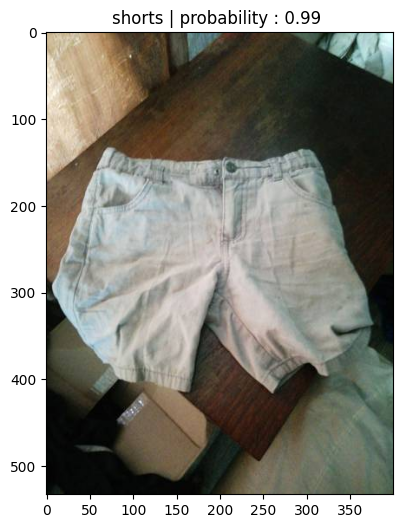

In [91]:
pred_image_label(model=efficientnet_b2,
                 transform=eff_transform,
                 dataset_path=train_path,
                 class_name=class_names)

# ViT

In [14]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    def __init__(self,
                 in_channels : int=3,
                 patch_size :int=16,
                 embedding_dim:int=768) -> None:
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
        self.patch_size = patch_size
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        x_patched = self.patcher(x)
        x_flattend = self.flatten(x_patched)
        return x_flattend.permute(0,2,1)

In [15]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dim:int=768,
                 num_head:int=12,
                 attn_dropout:float=0) -> None:
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_head,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    def forward(self,x):
        x = self.layer_norm(x)
        attn_output, _ =  self.multihead_attn(query = x,
                                              key= x,
                                              value=x,
                                              need_weights = False)
        return attn_output

In [1]:
class MLPBlock(nn.Module):
    """create a mlp(multi layer perseptron) block"""
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1) -> None:
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self,x):
        return self.mlp(self.layer_norm(x))

NameError: name 'nn' is not defined

In [17]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""

    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0) -> None:
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_head=num_heads,
                                                    attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
        

    def forward(self,x):
        #Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        
        #Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x
            

In [18]:
# # Create the same as above with torch.nn.TransformerEncoderLayer()
# torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
#                                                              nhead=12, # Heads from Table 1 for ViT-Base
#                                                              dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
#                                                              dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
#                                                              activation="gelu", # GELU non-linear activation
#                                                              batch_first=True, # Do our batches come first?
#                                                              norm_first=True) # Normalize first or after MSA/MLP layers?



In [19]:
class Vit(nn.Module):
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000) -> None:
        super().__init__()
        

        assert img_size % patch_size== 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        self.num_patches = (img_size * img_size) // patch_size**2
        
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim), requires_grad = True)

        self.position_embedding = nn.Parameter(torch.randn(1,1,embedding_dim),requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformerencoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                          num_heads=num_heads,
                                                                          mlp_size=mlp_size,
                                                                          mlp_dropout=mlp_dropout)for _ in range(num_transformer_layers)])
        

        self.classifier = nn.Sequential(nn.LayerNorm(
            normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes))
        

    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0]) 

        return x

In [20]:
vit_1 =  Vit().to(device)
vit_1

Vit(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(1, 1))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformerencoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (

In [21]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [22]:
train_dataloader_vit_1 , test_dataloader_vit_1 , val_dataloader_vit_1 , class_names_vit_1 , class_idx_vit_1 = creat_dataloaders(train_path=train_path,
                                                                                 test_path=test_path,
                                                                                val_path=val_path,
                                                                                batch_size=BATCH_SIZE,
                                                                                train_transform=manual_transforms,
                                                                                test_transform=manual_transforms,
                                                                                seed=42)

In [23]:
optimizer = torch.optim.Adam(params=vit_1.parameters(),
                             lr=3e-3, 
                             betas=(0.9, 0.999),
                             weight_decay=0.3) 


loss_fn = torch.nn.CrossEntropyLoss()


In [24]:
writer_vit_ = create_writer(experiment_name="vit_",
                                         model_name="ViT")

[INFO] Created SummaryWriter, saving to: runs/2023-11-24/vit_/ViT...


In [ ]:
model_results_vit_1 = train_model(model=vit_1,
                                  train_dataloader=train_dataloader_vit_1,
                                  test_dataloader=test_dataloader_vit_1,
                                  loss_function=loss_fn,
                                  optimizer=optimizer,epoch_number=10,
                                  metric_function=accuracy_score,
                                  device=device,
                                  writer=writer_vit_)

# Going Modular for doing more Experiments
1. Get Model Ready 

2. Get Data Ready --> to dataset(transforms) --> to DataLoaders (val_path)

3. Get Training Process Ready

4. Get Saving Process Ready

* Improve eff_b2 model (like cahnge learning rate)

# Use Powerfull Models
1. Xception (from project of Dataset)

2. Use Effic.... net Model

3. VGG

4. ViT (my buil model  and pretrained version)

## Increace Epochs

## Change Learning Rate

## Data Augmentation

# Add More Data

1. https://www.softr.io/blog/tools-to-extract-data-from-website

2. Web Scraping

3. Slice Big Datasets

## Use this article
* https://itnext.io/image-classification-in-2023-8ab7dc552115

## Fine_Tune